In [21]:
# FOR PREPARATION
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from glob import glob
import dicom2nifti
import dicom2nifti.settings as settings
settings. disable_validate_slice_increment()

# FOR PREPROCESSING
from preprocessing import show_image,prepare
import os
from glob import glob
import torch
from monai.transforms import Compose,LoadImaged,ToTensord,EnsureChannelFirstd,Spacingd,ScaleIntensityRanged,CropForegroundd,Resized,Activations
from monai.data import Dataset,DataLoader
from monai.utils import first
import matplotlib.pyplot as plt

# FOR TRAINING
import torch
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from fit_implementation import train

# FOR TESTING
from monai.inferers import sliding_window_inference





# DATA PREPARATION

## STEP 1 : Convert The Dicom Files (Manually Created) into Dicom Groups, each group consisting of SLICES number of slices



In [3]:
'''

input_image_path = '/Users/ansafhassan/Documents/Semester V/Image Processing/Group Project/Liver Segmentation/DICOM Files/Images'
input_label_path = '/Users/ansafhassan/Documents/Semester V/Image Processing/Group Project/Liver Segmentation/DICOM Files/Labels'
output_image_path = '/Users/ansafhassan/Documents/Semester V/Image Processing/Group Project/Liver Segmentation/DICOM Groups/Images'
output_label_path = '/Users/ansafhassan/Documents/Semester V/Image Processing/Group Project/Liver Segmentation/DICOM Groups/Labels'

SLICES = 64

# MOVING THE IMAGES FROM DICOM FILE -> DICOM GROUP

for patient in glob(input_image_path + '/*'):
    patient_name = os.path.basename(os.path.normpath(patient))
    
    number_of_files = int(len(glob(patient+'/*')))

    number_of_folders = int(number_of_files / SLICES)
    
    print(number_of_folders)
    
    for i in range(number_of_folders):
        folder_path = os.path.join(output_image_path, patient_name + '_' + str(i) )
        os.mkdir(folder_path)
        
        for i,file in enumerate(glob(patient + '/*') ):
            
            if i == SLICES + 1:
                break
            shutil.copy(file,folder_path)
      
        
# MOVING THE LABELS FROM DICOM FILE -> DICOM GROUP

for patient in glob(input_label_path + '/*'):
    patient_name = os.path.basename(os.path.normpath(patient))
    
    number_of_files = int(len(glob(patient+'/*')))

    number_of_folders = int(number_of_files / SLICES)
    
    print(number_of_folders)
    
    for i in range(number_of_folders):
        folder_path = os.path.join(output_label_path, patient_name + '_' + str(i) )
        os.mkdir(folder_path)
        
        for i,file in enumerate(glob(patient + '/*') ):
            
            if i == SLICES + 1:
                break
            shutil.copy(file,folder_path)
 
'''
print()

## STEP 2 : Convert the DICOM groups each into NIFTI files for both the images and the labels

In [3]:
'''
input_image_path = '/Users/ansafhassan/Documents/Semester V/Image Processing/Group Project/Liver Segmentation/DICOM Groups/Images'
input_label_path = '/Users/ansafhassan/Documents/Semester V/Image Processing/Group Project/Liver Segmentation/DICOM Groups/Labels'
output_image_path = '/Users/ansafhassan/Documents/Semester V/Image Processing/Group Project/Liver Segmentation/NIFTI Files/Images'
output_label_path = '/Users/ansafhassan/Documents/Semester V/Image Processing/Group Project/Liver Segmentation/NIFTI Files/Labels'


for file in glob(input_image_path + '/*'):
    patient_name = os.path.basename(os.path.normpath(file))
    dicom2nifti.dicom_series_to_nifti(file,os.path.join(output_image_path, patient_name + ".nii.gz"))



for file in glob(input_label_path + '/*'):
    patient_name = os.path.basename(os.path.normpath(file))
    dicom2nifti.dicom_series_to_nifti(file,os.path.join(output_label_path, patient_name + ".nii.gz"))
'''
print()

# DATA PREPROCESSING

## Call the Prepare function from the 'preprocessing.ipynb' function to return loaders for both the training an validation datasets.

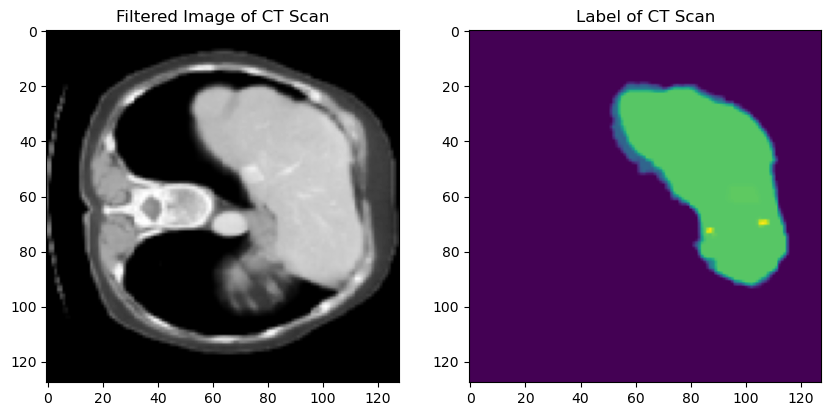

In [5]:
data_dir = '/Users/ansafhassan/Documents/Semester V/Image Processing/Group Project/Liver Segmentation/NIFTI Files'
model_dir = '/Users/ansafhassan/Documents/Semester V/Image Processing/Group Project/Liver Segmentation/Model Details'
data_input = prepare(data_dir,spatial_size=[128,128,64])
show_image(data_input[0],61)



# TRAINING THE MODEL

In [6]:
                      
# CREATE THE MODEL
epoch = 20

model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (16,32,64,128,256),
    strides = (2,2,2,2),
    num_res_units = 2,
    norm = Norm.BATCH
)


# CREATE THE LOSS FUNCTION AND OPTIMIZER
loss_function = DiceLoss(sigmoid=True,to_onehot_y=True,squared_pred=True)
optimizer_function = torch.optim.Adam(model.parameters(),1e-5,weight_decay=1e-5,amsgrad=True)


#train(model,data_input,loss_function,optimizer_function,20,model_dir,1,torch.device("cpu"))

# PLOT GRAPH OF LOSS

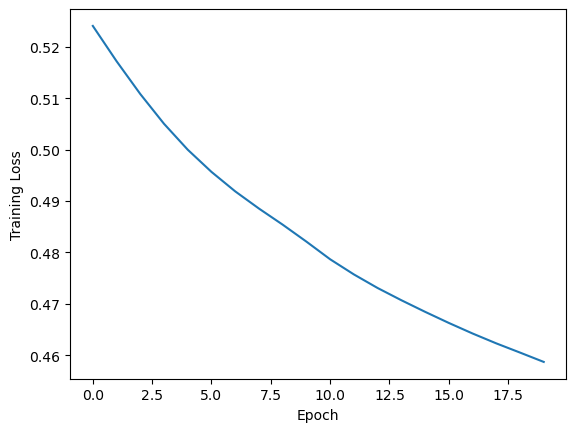

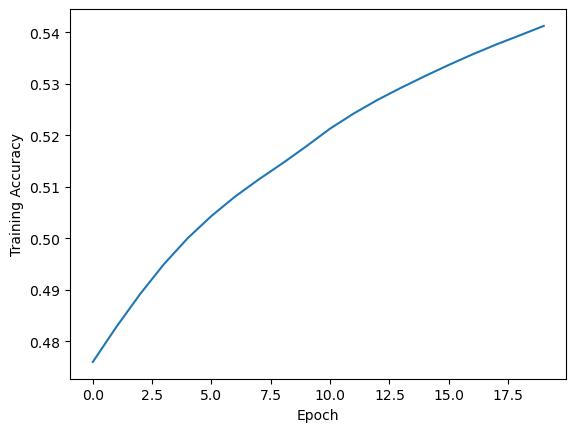

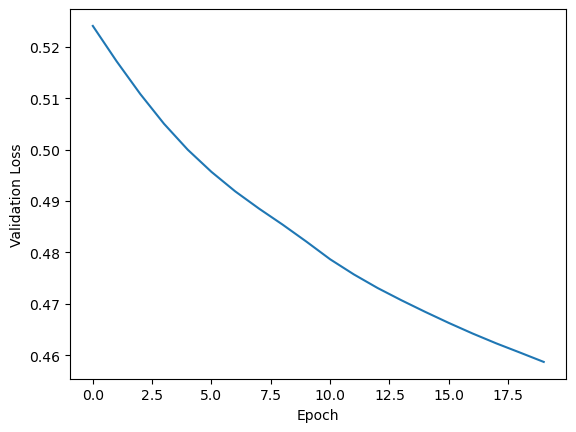

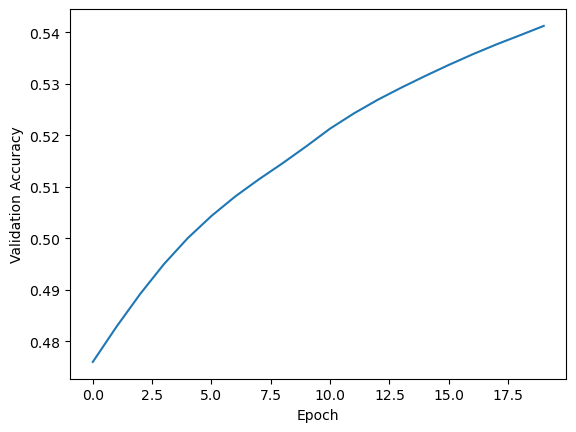

In [7]:
train_loss = np.load(os.path.join(model_dir,'training_loss.npy'))
test_loss = np.load(os.path.join(model_dir,'testing_loss.npy'))
train_metric = np.load(os.path.join(model_dir,'training_metric.npy'))
test_metric = np.load(os.path.join(model_dir,'testing_metric.npy'))

epoch = 20

x = [x for x in range(epoch)]
y = train_loss
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(x,y)
plt.show()

x = [x for x in range(epoch)]
y = train_metric
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(x,y)
plt.show()

x = [x for x in range(epoch)]
y = train_loss
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot(x,y)
plt.show()

x = [x for x in range(epoch)]
y = train_metric
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(x,y)
plt.show()




## TESTING WITH IMAGES FROM THE TEST_DATASET

In [29]:
test_images = sorted(glob(os.path.join(data_dir,'val_images','*.nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir,'val_labels','*.nii.gz')))

test_dict = [{"image":imagename,"label":labelname} for imagename,labelname in zip(test_images,test_labels)]

test_dict = test_dict[5:]

test_transforms = Compose([
    LoadImaged(keys=['image','label']),
    EnsureChannelFirstd(keys=['image','label'], channel_dim="no_channel"),
    Spacingd(keys=['image','label'],pixdim=(1.5,1.5,1)),
    ScaleIntensityRanged(keys=['image'],a_min=-200,a_max=200,b_min=0.0,b_max=1.0,clip=True),
    CropForegroundd(keys=['image','label'],source_key='image',allow_smaller = True),
    Resized(keys=['image','label'],spatial_size=[128,128,64]),
    ToTensord(keys=['image','label'])
])

test_dataset = Dataset(data=test_dict,transform=test_transforms)

test_loader = DataLoader(test_dataset,batch_size=1)


device = torch.device("cpu")

model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (16,32,64,128,256),
    strides = (2,2,2,2),
    num_res_units = 2,
    norm = Norm.BATCH
)

model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_model.pth")))
model.eval()


/var/folders/3n/x1v8jfsj4g19fr5wrqxt1lpw0000gn/T/ipykernel_18033/1070935594.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.joi

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


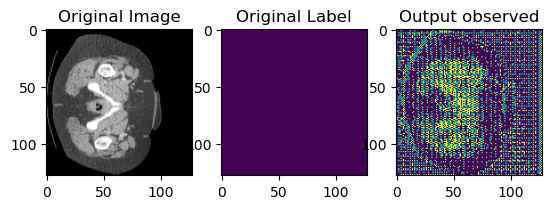

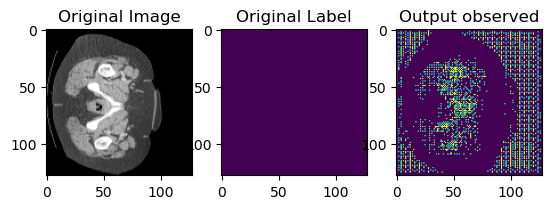

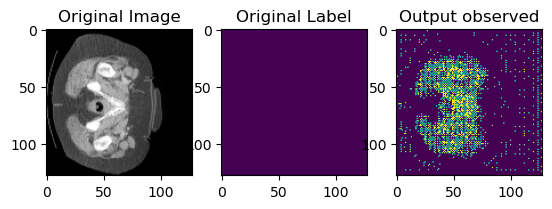

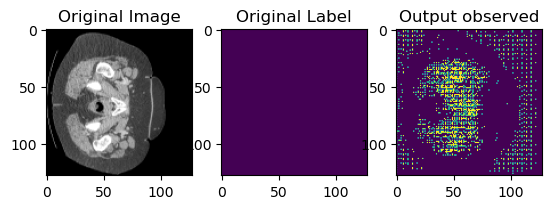

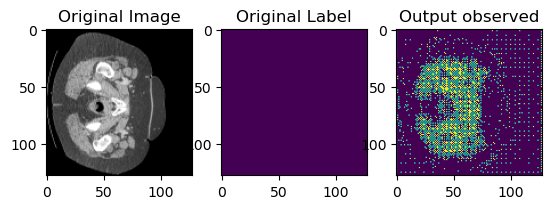

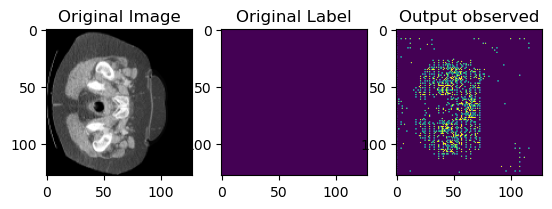

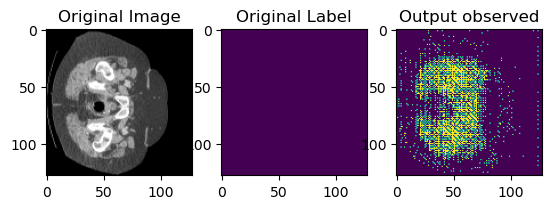

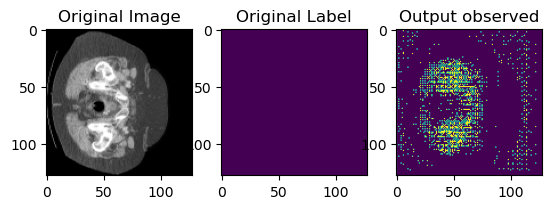

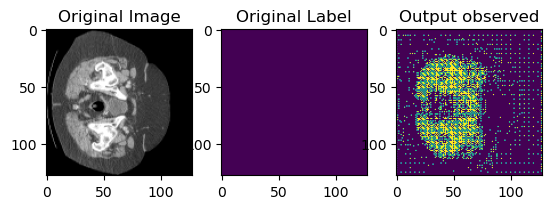

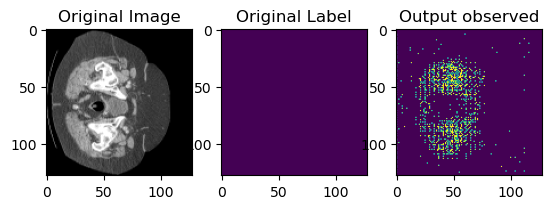

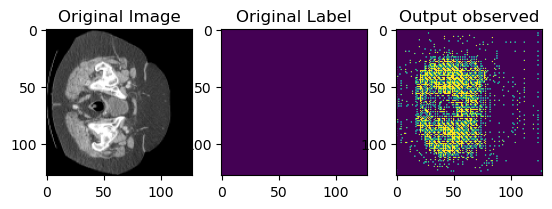

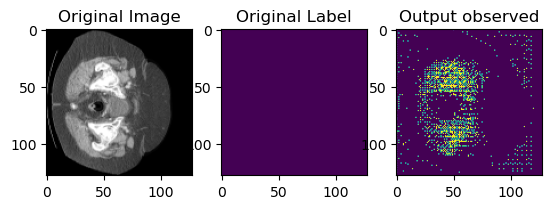

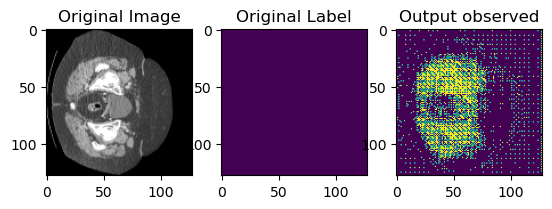

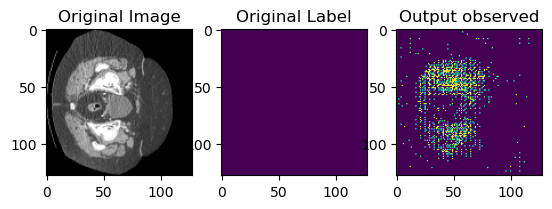

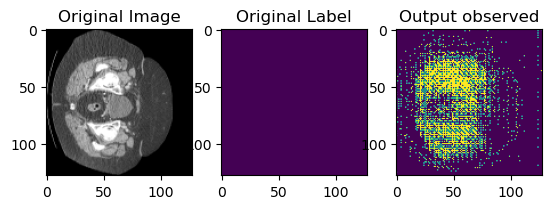

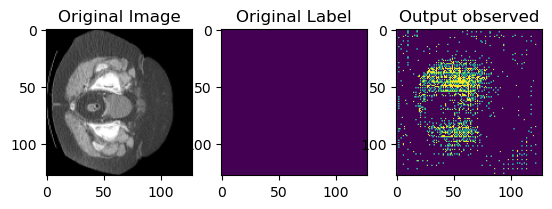

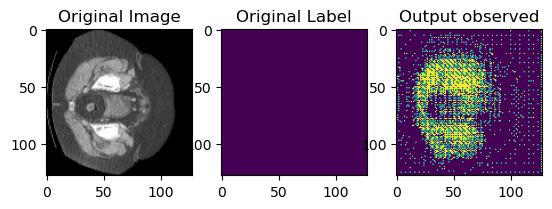

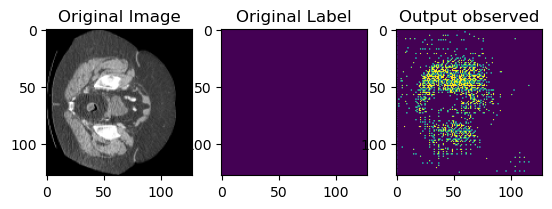

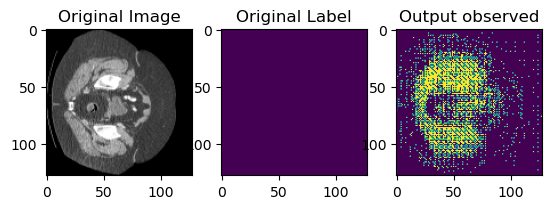

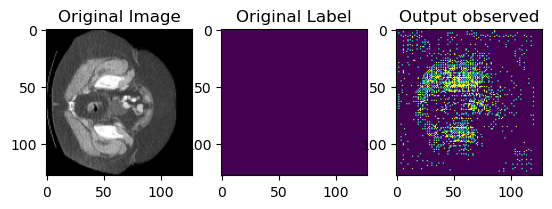

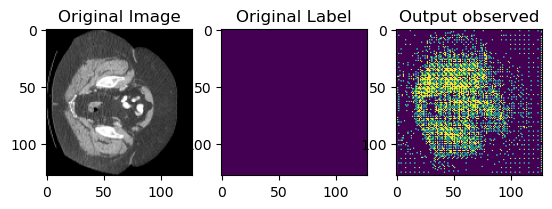

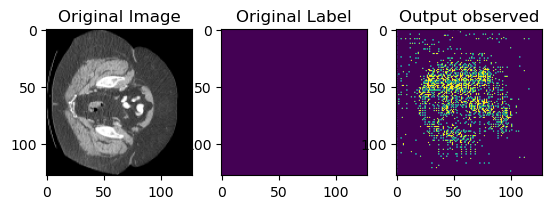

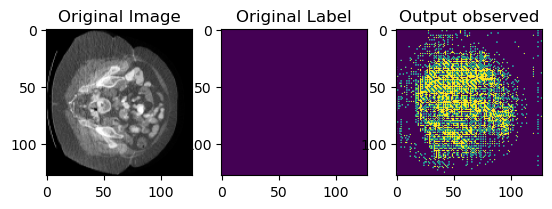

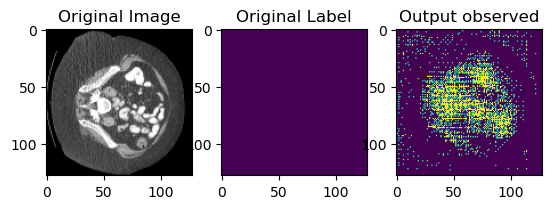

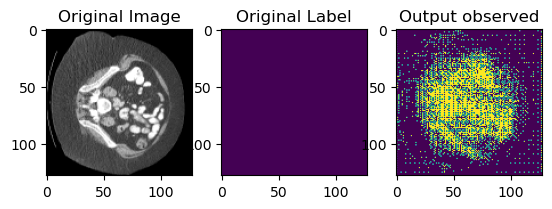

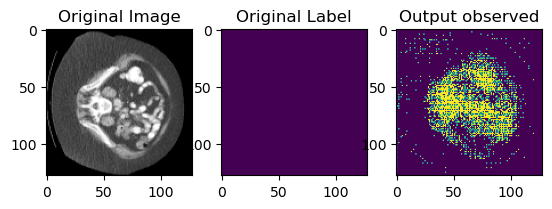

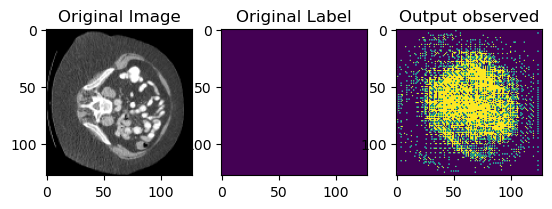

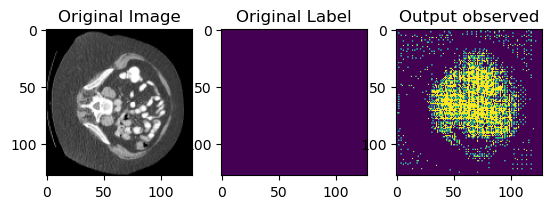

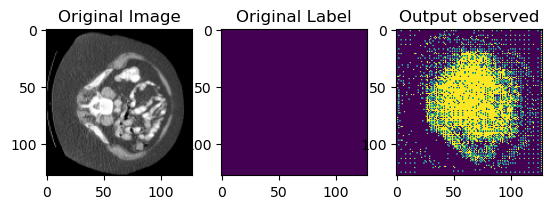

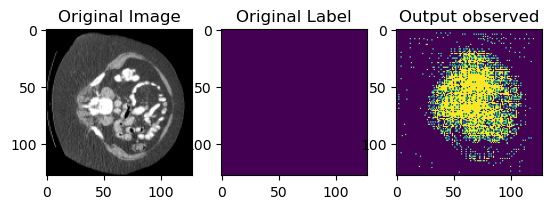

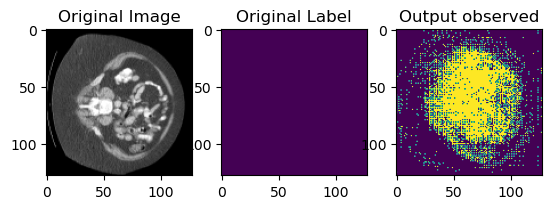

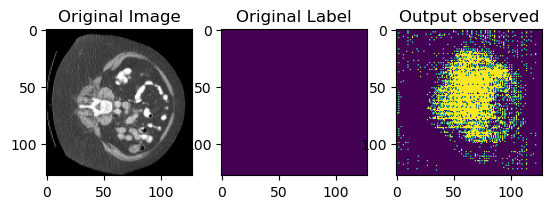

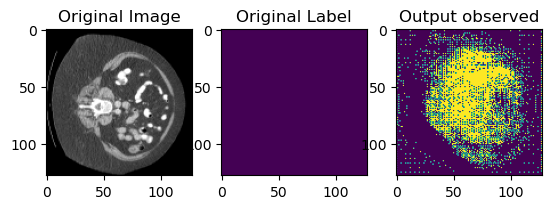

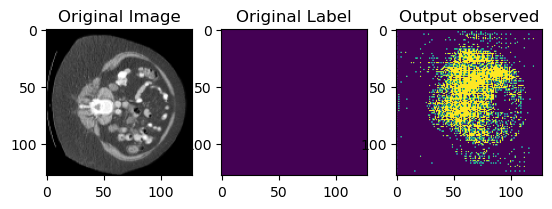

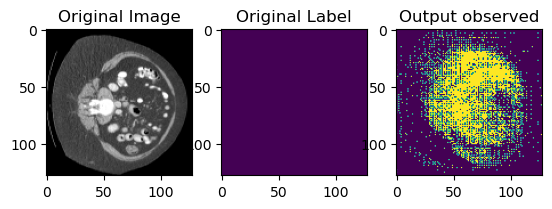

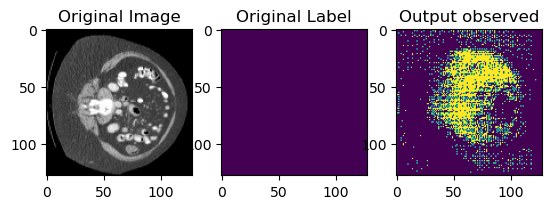

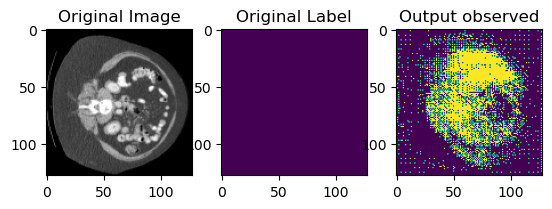

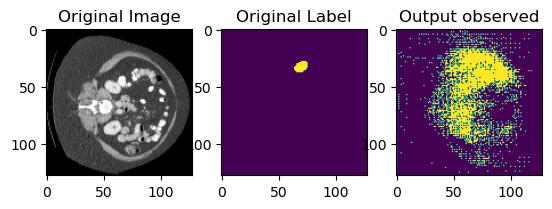

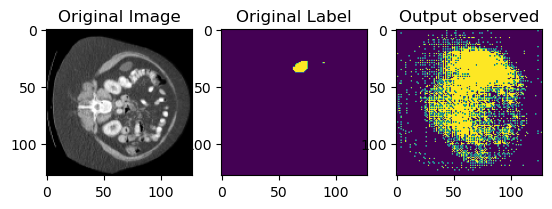

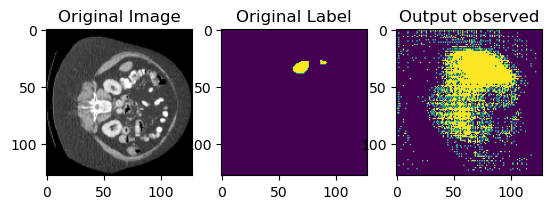

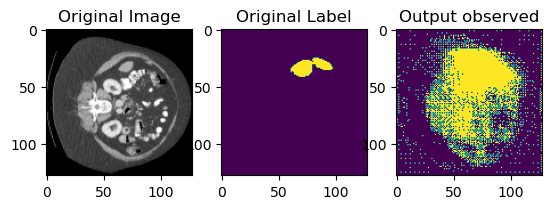

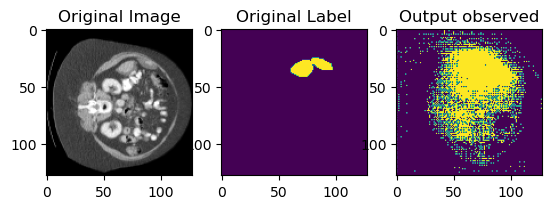

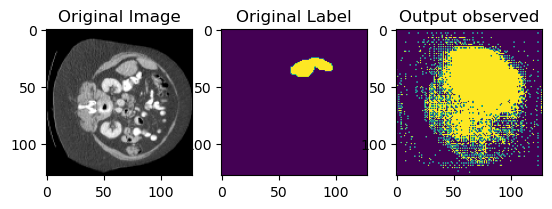

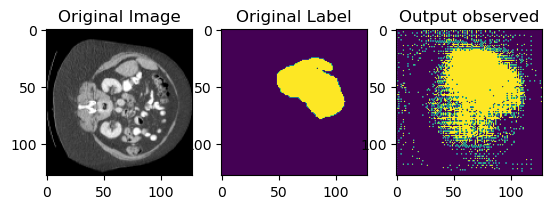

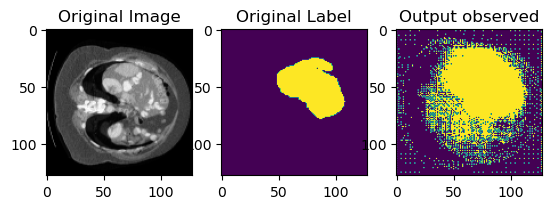

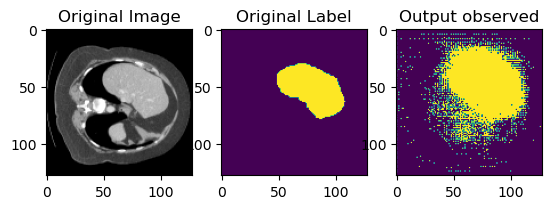

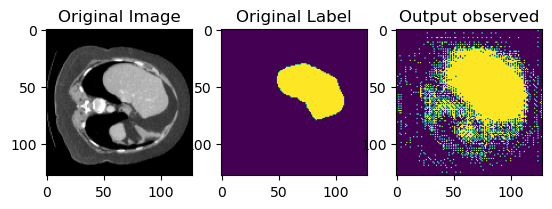

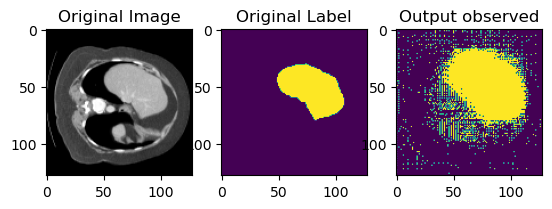

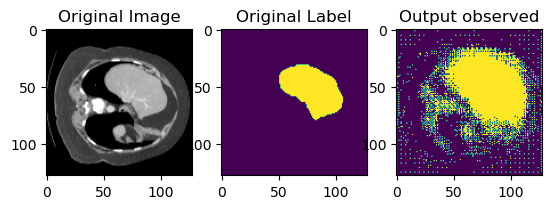

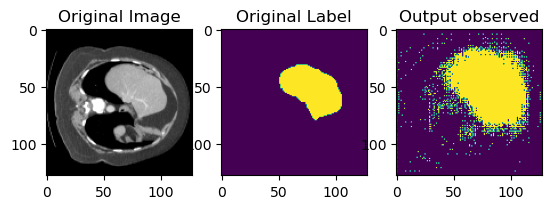

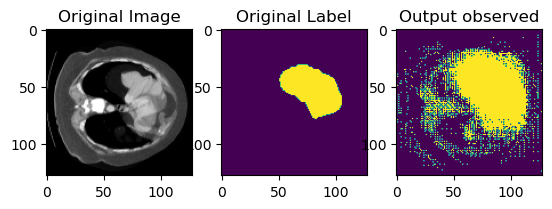

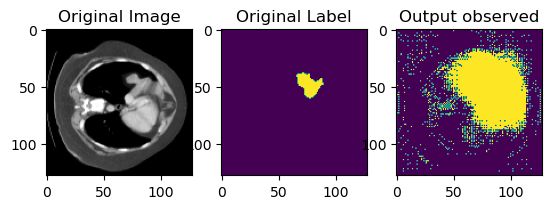

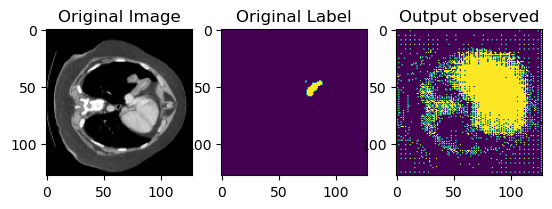

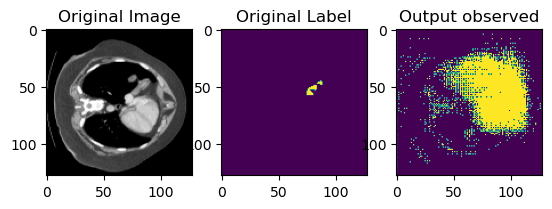

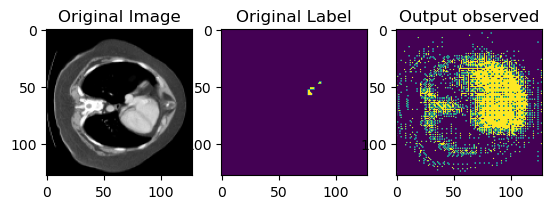

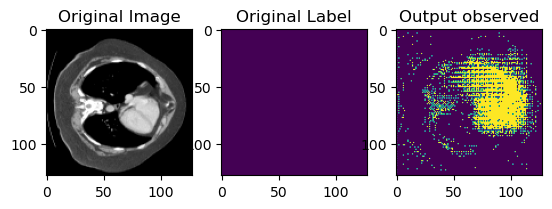

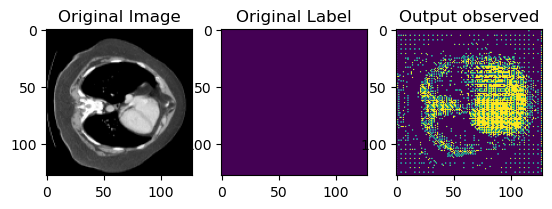

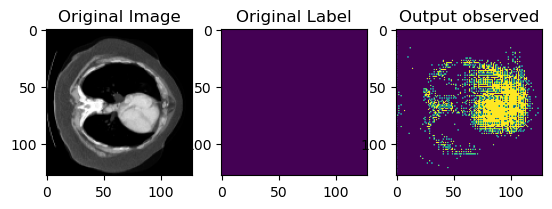

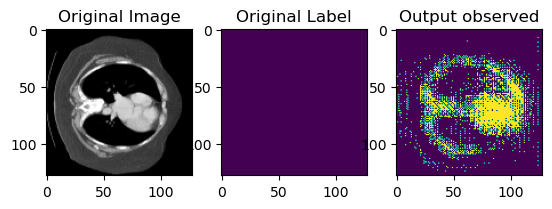

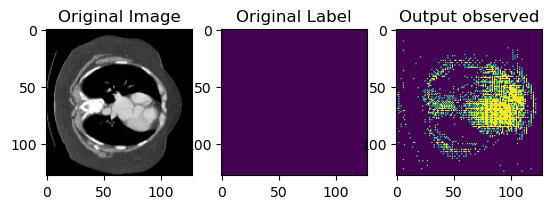

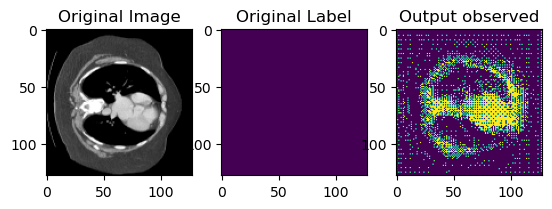

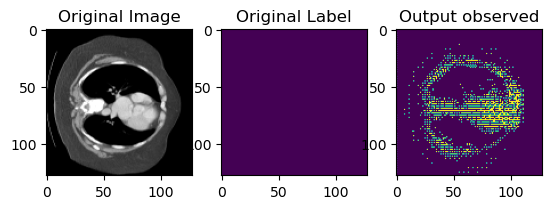

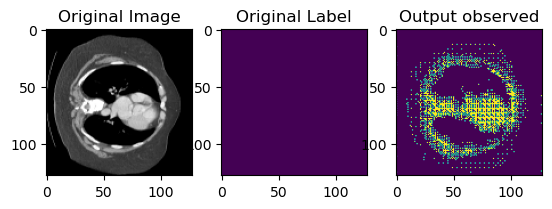

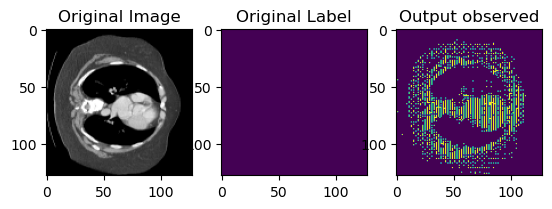

In [30]:
with torch.no_grad():
    patient = first(test_loader)
    image = patient["image"]
    test_output = sliding_window_inference(image.to(device),(128,128,64),4,model)
    sigmoid_activation = Activations(sigmoid=True)
    test_output = sigmoid_activation(test_output)
    test_output = test_output > 0.5
    
    for i in range(64):
        plt.figure("Outputs comparison")
        plt.subplot(1,3,1)
        plt.title("Original Image")
        plt.imshow(patient["image"][0,0,:,:,i],cmap="gray")
        plt.subplot(1,3,2)
        plt.title("Original Label")
        plt.imshow(patient["label"][0,0,:,:,i] != 0 )
        plt.subplot(1,3,3)
        plt.title("Output observed")
        plt.imshow(test_output.detach().cpu()[0,1,:,:,i])
        plt.show()